In [48]:
import numpy as np
import matplotlib.pyplot as plt

import os

import pandas as pd

from scipy import stats

import ipywidgets as widgets
from ipywidgets import interactive

In [2]:
gnss = pd.read_csv('MUCKENBACH_OS_2024.csv')
gnss['geophone'] = gnss['Name'].map(lambda e: int(e.split('.')[-1]))
gnss = gnss.set_index('geophone')
gnss = gnss.sort_index()
gnss.head()

,Name,Latitude,Longitude,EllipsoidHeight,TimeStamp,X,Y,A
geophone,,,,,,,,
1,ONDES.GR1.1,48.491419,7.288737,713.242974,2024-09-04T15:10:04.420,6.829844e+06,1.016730e+06,664.504873
2,ONDES.GR1.2,48.491391,7.288704,713.303219,2024-09-04T15:10:28.280,6.829841e+06,1.016728e+06,664.564993
3,ONDES.GR1.3,48.491363,7.288673,713.271782,2024-09-04T15:10:46.900,6.829837e+06,1.016726e+06,664.533426
4,ONDES.GR1.4,48.491334,7.288640,713.350197,2024-09-04T15:11:05.850,6.829834e+06,1.016723e+06,664.611712
5,ONDES.GR1.5,48.491305,7.288607,713.588551,2024-09-04T15:11:25.210,6.829831e+06,1.016721e+06,664.849936


Text(0, 0.5, 'Northing (m)')

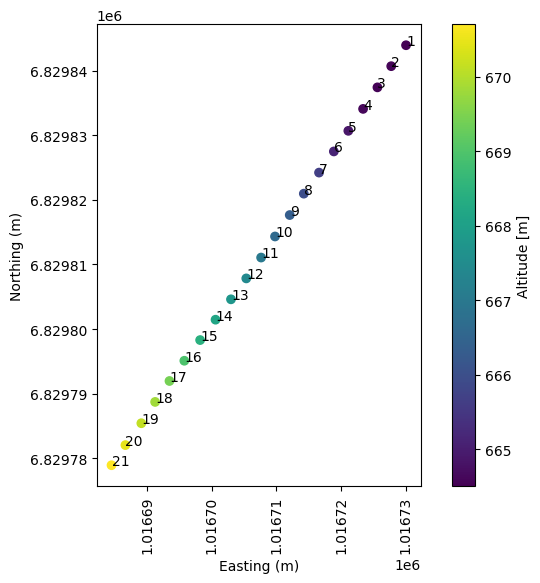

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for k, row in enumerate(gnss.iterrows()):
    k, serie = row
    plt.annotate(k, (serie[' Y '], serie[' X ']))
ax.set_aspect('equal', adjustable='box')

im = plt.scatter(gnss[' Y '], gnss[' X '], c=gnss['A'])
cb = plt.colorbar(im, label='Altitude [m]')

ax.get_yaxis().get_major_formatter().set_useOffset(False)
ax.get_xaxis().get_major_formatter().set_useOffset(False)
plt.xticks(rotation=90)
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')

In [4]:
files = [f for f in os.listdir('pointage') if f.endswith('txt')]

In [7]:
dx = 4
offset = 2
ng = len(gnss['A'].unique())
ns = len(files)
x_geoph = np.arange(ng)*dx # géophones espacés de 4m
x_shots = np.arange(ns)*dx + offset # sources espacées de 4m entre 2 géophones
x = np.concatenate((x_geoph, x_shots))
x.sort()
y_geoph = gnss['A'].values

y = np.interp(x, x_geoph, y_geoph) # interpolation de l'altitude des capteurs (mesurées) pour estimer celle des sources
xy = np.array((x, y)).T # positions de tous les capteurs et receveurs

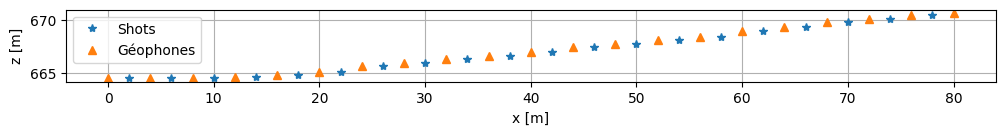

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 2))
plt.plot(x_shots, y[0:-1:2], '*', label='Shots')
plt.plot(x_geoph, y_geoph, '^', label='Géophones')
plt.grid()
ax.set_aspect('equal', adjustable='box')
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.legend()

In [42]:
s = np.zeros(ns*ng, dtype=int)
g = np.zeros(ns*ng, dtype=int)
t = np.zeros(ns*ng, dtype=float)
i = 0
with open('pointage.txt', 'r') as f: # reading this terrible file format
    for line in f.readlines():
        l = line.split()
        if len(l)>2:
            ti = l[0]
            d = l[1]
            with open(f'pointage/{ti}.txt', 'w') as f: # clear content of old file
                pass
        else:
            if l:
                d = l[0]
            else:
                continue
        shot = int(float(ti)/1000-2)//4+1
        geophone = int(float(l[-1]))
        
        if shot == geophone:
            pass
            #print("Retire le pointé", geophone, "du shot", shot, "(source au même endroit que le pointé)")
            #continue
        # le shot et le geophone sont au même endroit donc on peut utiliser une position pour les 2
        
        s[i] = 2*shot
        g[i] = 2*geophone-1
        t[i] = float(d)
        i += 1
        
        with open(f'pointage/{ti}.txt', 'a') as f:
            f.write(d+'\n')

In [43]:
print('Nombre de geophones', ng)
print('Nombre de shots (sources)', ns)
print('Nombre total de positions', len(xy)) # car les shots sont aux positions des capteurs donc on ne les compte pas
print('Nombre total de données', ns*ng)
print('Nombre total de données réelles', len(t)) # en réalité on en retire 1 par shot soit 20

Nombre de geophones 21
Nombre de shots (sources) 20
Nombre total de positions 41
Nombre total de données 420
Nombre total de données réelles 420


In [44]:
np.savetxt('data/sgt/positions.txt', np.array(xy))
np.savetxt('data/sgt/shots.txt', np.array(s))
np.savetxt('data/sgt/geophones.txt', np.array(g))
np.savetxt('data/sgt/times.txt', np.array(t))
np.savetxt('data/sgt/sgt.txt', np.array([s, g, t]).T) # , delimiter='\t', fmt='%.5f'

In [45]:
with open('data.sgt', 'w') as f:
    f.write(f'{len(xy)} # shot/geophone points\n')
    f.write('#x	y\n')
    #f.write(open('xy', 'r').read())
    for pos in xy:
        x, y = pos
        f.write(f'{x} {y}\n')
    f.write(f'{len(t)} # measurements\n')
    f.write('#s	g	t\n')
    #f.write(open('sgt', 'r').read())
    for i in range(len(t)):
        f.write(f'{s[i]} {g[i]} {t[i]}\n')

In [56]:
def scatterplt(choosen_shot=12.75, geophones=[0, -1]):
    
    ii = np.where(xy[s-1][:, 0] == choosen_shot)
    xgeoph = xy[g[ii]-1][:, 0]
    times = t[ii]
    jj = np.where((xgeoph >= geophones[0]) & (xgeoph <= geophones[1]))
    xreg = xgeoph[jj]
    tslice = times[jj]
    slope, intercept, r, p, std_err = stats.linregress(xreg, tslice)
    treg = slope * xreg + intercept
    print(f'v={1/slope} m/s')
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 2))
    
    ax.scatter(choosen_shot, 0, c='red', marker='*')
    ax.scatter(xgeoph, [0]*len(xgeoph), c='green', marker='^')
    ax.scatter(xgeoph, times, c='black', marker='+')
    plt.axvline(geophones[0], linestyle=':', color='grey')
    plt.axvline(geophones[1], linestyle=':', color='grey')
    ax.plot(xreg, treg, c='blue', label=f'v={np.abs(1/slope):.1f} m/s')
    ax.set_xlabel('Distance [m]')
    ax.set_ylabel('Traveltime [m]')
    ax.legend()
    ax.invert_yaxis()
    
    plt.show()

In [61]:
interactive_plot = interactive(scatterplt, choosen_shot=widgets.SelectionSlider(
    options=list(x_shots),
    value=x_shots[ns//2],
    description='Position du shot',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
), geophones=widgets.IntRangeSlider(
    value=[x_geoph[0], x_geoph[ng//3]],
    min=np.min(x_geoph),
    max=np.max(x_geoph),
    step=dx,
    description='Geophones',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
))
interactive_plot